# 用sklearn封装kares模型 进行超参数搜索

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras
print(tf.__version__)
print(sys.version_info)
for module in np, pd ,sklearn, tf, keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [4]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

# print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)


(20640, 8)
(20640,)


In [5]:
from sklearn.model_selection import train_test_split

x_train_all,x_test,y_train_all,y_test=train_test_split(housing.data, housing.target,random_state=7)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all,y_train_all,random_state=11)

In [6]:
from sklearn.preprocessing import StandardScaler
transfer = StandardScaler()
x_train_scaled = transfer.fit_transform(x_train)
x_test_scaled = transfer.transform(x_test)
x_valid_scaled = transfer.transform(x_valid)

In [7]:
# RandomizedSearchCV实现超参数搜索
# 1、转化为sklearn 的model
# 2、定义参数集合
# 3、搜索参数
def build_model(hidden_layers = 1, layer_size = 30, learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',input_shape = x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,activation='relu'))
    model.add(keras.layers.Dense(1))
    
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

# 将keras_model转为sklearn_model，参数为一个函数
sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [11]:
callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]
history = sklearn_model.fit(x_train_scaled,y_train,epochs=10,
                  validation_data=(x_valid_scaled,y_valid), 
                  callbacks= callbacks )

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 2s 215us/sample - loss: 1.1432 - val_loss: 0.7485
Epoch 2/10
11610/11610 [==============================] - 1s 111us/sample - loss: 0.6461 - val_loss: 0.6596
Epoch 3/10
11610/11610 [==============================] - 1s 106us/sample - loss: 0.5784 - val_loss: 0.5927
Epoch 4/10
11610/11610 [==============================] - 1s 108us/sample - loss: 0.5317 - val_loss: 0.5507
Epoch 5/10
11610/11610 [==============================] - 1s 107us/sample - loss: 0.5005 - val_loss: 0.5250
Epoch 6/10
11610/11610 [==============================] - 1s 106us/sample - loss: 0.4796 - val_loss: 0.5014
Epoch 7/10
11610/11610 [==============================] - 1s 106us/sample - loss: 0.4625 - val_loss: 0.4841
Epoch 8/10
11610/11610 [==============================] - 1s 108us/sample - loss: 0.4494 - val_loss: 0.4743
Epoch 9/10
11610/11610 [==============================] - 1s 110us/sample - loss: 0.440

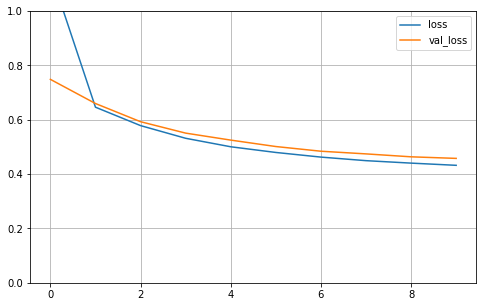

In [12]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=[8,5])
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [ ]:
model.evaluate(x_test_scaled,y_test,verbose=2)


In [ ]:
sklearn_model = keras.estimator.model_to_estimator(model)

In [16]:
from scipy.stats import reciprocal# 生成一个区间里连续的分布
param_distribution={
    'hidden_layers': [1,2,3,4],
    'layer_size': np.arange(1,100),
    'learning_rate': reciprocal(1e-4,1e-2)
    }
from sklearn.model_selection import RandomizedSearchCV
estimator = RandomizedSearchCV(sklearn_model, #模型estimator
                                                 param_distribution,#定义好的搜索空间
                                                 n_iter = 10,#要搜索的参数集合数量
                                                 n_jobs = 5#并行处理数据数量
                                                  )

callbacks = [keras.callbacks.EarlyStopping(patience=5,min_delta=1e-2)]
estimator.fit(x_train_scaled,y_train,epochs=100,
                  validation_data=(x_valid_scaled,y_valid), 
                  callbacks= callbacks)

KeyboardInterrupt: 

In [13]:
# reciprocal函数演示
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a))     a<x<b
reciprocal.rvs(1e-4, 1e-2, size =10)
# print(reciprocal(1e-4, 1e-2))#, size =10)

array([0.00069507, 0.00021399, 0.0031691 , 0.00011153, 0.00315605,
       0.0013528 , 0.001689  , 0.00074715, 0.00098118, 0.00041655])

In [ ]:
#最佳参数
print('最佳参数：\n',estimator.best_params_)
#最佳结果
print('最佳结果:\n',estimator.best_score_)
#最佳估计器
print('最佳估计器：\n',estimator.best_estimator_)
#交叉验证结果
# print('交叉验证结果:\n',estimator.cv_results_)

In [ ]:
model = estimator.best_estimator_.model
model.evaluate(x_test_scaled, y_test)